# Reference points


## Question

Do reference points have comparable positions among all structures?

## Experiment

* Centroid: Distances of centroids with respect to reference centroid
* Hinge/DFG region: Distances of reference points to the 3 residues of hinge/DFG region
* Front region: Distances of front region reference points to reference front pocket reference point

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from itertools import combinations
from pathlib import Path
import random
import sys

import matplotlib.pyplot as plt
import pandas as pd
import scipy

sys.path.append('../..')
from kinsim_structure.auxiliary import KlifsMoleculeLoader
from kinsim_structure.encoding import SpatialFeatures

In [4]:
pd.set_option('display.max_rows', 100)

## IO paths

In [5]:
path_to_kinsim = Path('/') / 'home' / 'dominique' / 'Documents' / 'Projects' / 'kinsim_structure'
path_to_data = Path('/') / 'home' / 'dominique' / 'Documents' / 'data' / 'kinsim' / '20190724_full'

path_to_results = path_to_kinsim / 'examples'/ 'results'

metadata_path = path_to_data / 'postprocessed' / 'klifs_metadata_postprocessed.csv'

## Load metadata

In [6]:
klifs_metadata = pd.read_csv(metadata_path, index_col=0)
klifs_metadata.set_index('metadata_index', drop=True, inplace=True)
klifs_metadata.head()

,kinase,family,groups,pdb_id,chain,alternate_model,species,ligand_orthosteric_name,ligand_orthosteric_pdb_id,ligand_allosteric_name,...,ac_helix,rmsd1,rmsd2,qualityscore,pocket,resolution,missing_residues,missing_atoms,full_ifp,code
metadata_index,,,,,,,,,,,,,,,,,,,,,
2886,AAK1,NAK,Other,4wsq,B,A,Human,K-252A,KSA,-,...,in,0.777,2.125,8.6,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.95,0,14,0000000000000010000001000000000000000000000000...,HUMAN/AAK1/4wsq_chainB_altA
10043,AAK1,NAK,Other,5l4q,A,A,Human,"~{N}-[5-(4-cyanophenyl)-1~{H}-pyrrolo[2,3-b]py...",LKB,-,...,in,0.780,2.137,9.7,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.97,0,3,0000000000000010000000000000000000000000000000...,HUMAN/AAK1/5l4q_chainA_altA
7046,AAK1,NAK,Other,5te0,A,-,Human,methyl (3Z)-3-{[(4-{methyl[(4-methylpiperazin-...,XIN,-,...,in,0.776,2.120,8.8,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.90,0,12,1000101000000010000001000000000000000000000000...,HUMAN/AAK1/5te0_chainA
843,ABL1,Abl,TK,2f4j,A,-,Human,CYCLOPROPANECARBOXYLIC ACID {4-[4-(4-METHYL-PI...,VX6,-,...,in,0.779,2.128,8.0,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,1.91,0,0,0000000000000010000001000000000000000000000000...,HUMAN/ABL1/2f4j_chainA
815,ABL1,Abl,TK,2g1t,A,-,Human,-,-,-,...,out,0.825,2.154,8.0,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,1.80,0,0,NaN,HUMAN/ABL1/2g1t_chainA


## Reference structure `2wo6_A`

In [7]:
# Technically reference structure is 2wo6, chain A, alternate model A but only B/B is in dataset
klifs_metadata_reference = klifs_metadata[klifs_metadata.pdb_id == '2wo6']
klifs_metadata_reference

,kinase,family,groups,pdb_id,chain,alternate_model,species,ligand_orthosteric_name,ligand_orthosteric_pdb_id,ligand_allosteric_name,...,ac_helix,rmsd1,rmsd2,qualityscore,pocket,resolution,missing_residues,missing_atoms,full_ifp,code
metadata_index,,,,,,,,,,,,,,,,,,,,,
2818,DYRK1A,DYRK,CMGC,2wo6,B,B,Human,N-(5-{[(2S)-4-amino-2-(3-chlorophenyl)butanoyl...,D15,-,...,in,0.775,2.11,8.0,SLIGKGSFGQVVKVAIKIIQAQIEVRLLELMNYYIVHLKRHCLVFE...,2.5,0,0,0000000000000010000001000000100000010000000000...,HUMAN/DYRK1A/2wo6_chainB_altB


In [8]:
klifs_metadata_reference.index[0]

2818

In [9]:
def get_cgo_filename_from_metadata_index(metadata_index):
    """
    Get the cgo filename based on the metadata index.
    
    Parameters
    ----------
    metadata_index : int
        Metadata index.
        
    Returns
    -------
    str
        Cgo filename.
    """
    
    klifs_metadata_entry=klifs_metadata.loc[metadata_index]
    ml = KlifsMoleculeLoader(klifs_metadata_entry=klifs_metadata_entry)
    
    filename = ml.file_from_metadata_entry(klifs_metadata_entry=klifs_metadata_entry)
    
    return f'refpoints_{filename.parent.parent.stem}_{filename.parent.stem}.py'

In [10]:
get_cgo_filename_from_metadata_index(klifs_metadata_reference.index[0])

'refpoints_DYRK1A_2wo6_altB_chainB.py'

## Reference points

Get the coordinates for 4 reference points per structure.

In [11]:
def get_reference_points(klifs_metadata):
    """
    Get reference point from KLIFS metadata.
    
    Parameters
    ----------
    klifs_metadata : pandas.DataFrame
        Metadata KLIFS table.
    
    Returns
    -------
    pandas.DataFrame
        Reference point table, containing columns = reference points, index = (metadata index, coordinates).
    """
    
    reference_points = {}

    for index, row in klifs_metadata.iterrows():

        # Load structural data
        ml = KlifsMoleculeLoader(klifs_metadata_entry=row)
        
        # Calculate spatial features
        spatial = SpatialFeatures()
        spatial.from_molecule(ml.molecule)

        # Get reference points and save to dict with metadata index as key
        reference_points[row.name] = spatial.reference_points
        
    # Concatenate data from all structures
    reference_points = pd.concat(reference_points, axis=0)
    reference_points.index.set_names(['id', 'coordinate'], inplace=True)
    
    return reference_points

In [12]:
reference_points = pd.read_csv(
    path_to_results / 'reference_points' / 'coordinates_reference_points.csv',
    index_col=['id', 'coordinate']
)
print(reference_points.shape)
reference_points.head()

(11634, 4)


centroid  hinge_region  dfg_region  front_pocket
id    coordinate                                                   
2886  x            1.026635      1.976200    7.410200     -0.735833
      y           20.789879     21.758433   20.057467     15.892600
      z           36.404018     41.804733   33.520733     39.503467
10043 x            1.047804      2.009300    7.346733      0.313867
      y           21.004120     21.944700   20.813700     16.005333

## Hinge and DFG residues

Get coordinates for the 3 residues of the hinge and DFG region

In [13]:
def get_hinge_dfg_ca(klifs_metadata):
    """
    Get CA atoms of hinge and DFG region.
    
    Parameters
    ----------
    klifs_metadata : pandas.DataFrame
        Metadata KLIFS table.
    
    Returns
    -------
    pandas.DataFrame
        CA atoms of hinge and DFG region, containing columns = (region, residue ID), 
        index = (metadata index, coordinates).
    """
    
    # KLIFS residue IDs for hinge and DFG region
    hinge_residues = [46, 47, 48]
    dfg_residues = [81, 82, 83]
    
    hinge_dfg_ca = {}

    for index, row in klifs_metadata.iterrows():

        # Load structural data
        ml = KlifsMoleculeLoader(klifs_metadata_entry=row)
        molecule = ml.molecule
        
        # Define which atoms to select (CA atoms for hinge/DFG region)
        condition = (molecule.df.atom_name == 'CA') & (molecule.df.klifs_id.isin(hinge_residues+dfg_residues))

        # Get coordinates and format DataFrame: rows = coordinates and columns = residue IDs
        coordinates = molecule.df[condition]['x y z klifs_id'.split()]
        coordinates.set_index('klifs_id', drop=True, inplace=True)
        coordinates = coordinates.transpose()
        coordinates.columns.set_names(['residues'], inplace=True)
        
        hinge_dfg_ca[row.name] = coordinates
        
    # Concatenate data from all structures
    hinge_dfg_ca = pd.concat(hinge_dfg_ca, axis=0)
    hinge_dfg_ca.index.set_names(['id', 'coordinate'], inplace=True)
    
    # Split DataFrame by region
    hinge_dfg_ca = {
     'hinge_region': hinge_dfg_ca.loc[:, hinge_residues],
     'dfg_region':  hinge_dfg_ca.loc[:, dfg_residues]
    }
    
    # Concatenate again with multi-index column (region, residues)
    hinge_dfg_ca = pd.concat(hinge_dfg_ca.values(), axis=1, keys=hinge_dfg_ca.keys())
    
    return hinge_dfg_ca

In [14]:
# Read multi-index and multi-column CSV file... ugly.
hinge_dfg_ca = pd.read_csv(
    path_to_results / 'reference_points' / 'coordinates_hinge_dfg_ca.csv', 
    skiprows=2,
    index_col=['id', 'coordinate']
)

col_index = pd.MultiIndex.from_frame(
    pd.DataFrame(
        [
            ['hinge_region', 46], ['hinge_region', 47], ['hinge_region', 48],
            ['dfg_region', 81], ['dfg_region', 82], ['dfg_region', 83]
        ],
        columns=['region', 'residues']
    )
)
hinge_dfg_ca.columns = col_index

hinge_dfg_ca.head()

region           hinge_region                   dfg_region                  
residues                   46       47       48         81       82       83
id    coordinate                                                            
2886  x                0.4799  -0.3060  -3.7619     1.5806   2.8018   5.7823
      y               26.3014  23.3326  21.9317    19.3573  21.5128  19.2963
      z               43.8558  46.1435  45.3376    33.5495  30.6353  30.0596
10043 x                0.2635  -0.1987  -3.5961     1.5488   2.5897   5.8670
      y               25.9876  22.9660  21.3855    19.5079  21.6241  19.7742

## Distance reference points to hinge/DFG region

In [15]:
def get_distances(reference_points, hinge_dfg_ca, region):
    """
    Get reference point from KLIFS metadata.
    
    Parameters
    ----------
    reference_points : pandas.DataFrame
        Reference point table, containing columns = reference points, index = (metadata index, coordinates).
    hinge_dfg_ca : pandas.DataFrame
        CA atoms of hinge and DFG region, containing columns = (region, residue ID), 
        index = (metadata index, coordinates).
    region : str
        Region to be selected: 'hinge_region' or 'dfg_region'
    
    Returns
    -------
    pandas.DataFrame
        Distances from reference point to residues, containing columns = residues, index = metadata index.
    """
    
    # Selected region
    regions = ['hinge_region', 'dfg_region']
    if region not in regions:
        raise ValueError(f'Region unknown. Choose from: {", ".join(regions)}')
    
    # Not processed structures
    not_processed = []
    
    # Get metadata ID
    metadata_ids = [i[0] for i in reference_points.groupby(level='id', sort=False)]
    
    distances = {}

    for metadata_id in metadata_ids:

        try:
            # Calculate vector between points
            vectors = hinge_dfg_ca.loc[metadata_id][region].sub(
                reference_points.loc[metadata_id][region], 
                axis=0
            )

            # Calculate vector norm (distance)
            distance = vectors.apply(lambda x: scipy.linalg.norm(x), axis=0)

        except ValueError:
            not_processed.append(metadata_id)
            continue

        distances[metadata_id] = distance
        
    distances = pd.concat(distances, axis=1).transpose()
    distances.index.name = 'id'

    return distances, not_processed

In [16]:
def save_cgo_outliers(distances, region_name, path_to_results):
    """
    Save cgo files with outlier structures.
    """
    
    if isinstance(distances, pd.Series):
        distances = pd.DataFrame(distances)
    
    region_residues = {
        'hinge': [48, 47, 46],  # Distances to hinge residues
        'dfg': [81, 82, 83],  # Distances to DFG residues
        'centroid': 'centroid',  # Distances to reference centroid
        'hinge_region': 'hinge_region',  # Distances to reference hinge region reference point
        'dfg_region': 'dfg_region',  # Distances to reference DFG region reference point
        'front_pocket': 'front_pocket'  # Distances to reference front pocket reference point
    }
    
    reference_index = [int(klifs_metadata_reference.index[0])]
    outlier_indices = list(distances.sort_values(
        by=region_residues[region_name], 
        ascending=False
    ).head(20).index)

    commands = [f'run {get_cgo_filename_from_metadata_index(ix)}' for ix in reference_index+outlier_indices]

    with open(path_to_results / 'reference_points' / 'cgo_reference_points' / f'run_cgo_outliers_{region_name}.txt', 'w') as f:
        f.write('\n'.join(commands))

### Hinge region

In [17]:
distances_hinge, not_processed = get_distances(reference_points, hinge_dfg_ca, 'hinge_region')

In [18]:
len(not_processed)

8

In [19]:
def check_hinge_residues(metadata_ids):
    """
    Check available hinge residues in structures by metadata id.
    
    Parameters
    ----------
    metadata_ids : list of int
        Metadata IDs for structures.
    """
    
    print('Available hinge residues:')
    
    for metadata_id in metadata_ids:
        klifs_metadata_entry = klifs_metadata.loc[metadata_id]
        ml = KlifsMoleculeLoader(klifs_metadata_entry=klifs_metadata_entry)
        print(f'{klifs_metadata_entry.name}: {ml.molecule.df[ml.molecule.df.klifs_id.isin([46, 47, 48])].klifs_id.unique()}')

In [20]:
check_hinge_residues(not_processed)

Available hinge residues:
3130: [46]
1399: [46 47 48]
2193: [46 48]
2187: [46 48]
2166: [46 48]
2196: [46 48]
6856: [47 48]
2302: [46 47 48]


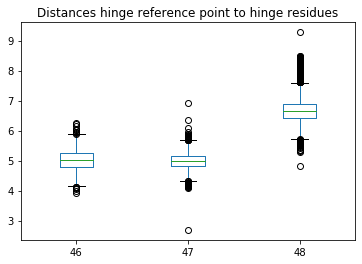

In [21]:
plot_hinge = distances_hinge.plot(
    kind='box', 
    title='Distances hinge reference point to hinge residues'
)

In [22]:
plot_hinge.get_figure().savefig(
    path_to_results / 'reference_points' / 'distance_hinge_refpoint-residues.png',
    dpi=300
)

In [23]:
distances_hinge.sort_values(by=[48, 47, 46], ascending=False).head()

residues,46,47,48
id,,,
1430,5.757893,6.357279,9.280369
1812,5.100716,5.286227,8.491359
4679,5.056278,5.259119,8.489358
1821,5.061281,5.167992,8.470243
6102,5.238595,5.260629,8.442288


In [24]:
save_cgo_outliers(distances_hinge, 'hinge', path_to_results)

### DFG region

In [25]:
distances_dfg, not_processed = get_distances(reference_points, hinge_dfg_ca, 'dfg_region')

In [26]:
len(not_processed)

90

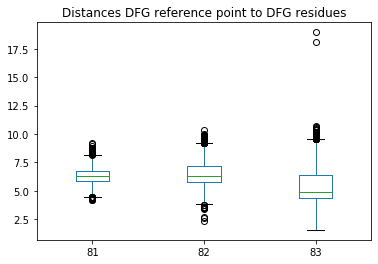

In [27]:
plot_dfg = distances_dfg.plot(
    kind='box', 
    title='Distances DFG reference point to DFG residues'
)

In [28]:
plot_dfg.get_figure().savefig(
    path_to_results / 'reference_points' / 'distance_dfg_refpoint-residues.png',
    dpi=300
)

In [29]:
distances_dfg.sort_values(by=[83, 82, 81], ascending=False).head()

residues,81,82,83
id,,,
7170,6.861162,7.408181,18.958419
1593,6.987313,6.971888,18.082801
6867,7.098741,10.364892,10.696183
3826,7.340665,9.533544,10.643996
9666,7.467104,9.710361,10.558241


In [30]:
save_cgo_outliers(distances_dfg, 'dfg', path_to_results)

## Distance reference points to reference

### Centroids

In [31]:
def get_distances_to_reference(reference_points, klifs_metadata_reference):
    """
    Get distances of reference points to their "reference" reference points.
    
    Parameters
    ----------
    reference_points : pandas.DataFrame
        Coordinates of all reference points for all structures.
    klifs_metadata_reference : pandas.DataFrame
        Metadata for reference KLIFS structure (reference = structure that was used to define anchor residues).
    
    Returns
    -------
    pandas.DataFrame
        Distances of all reference points to the "reference" reference points for all structures, 
        row = metadata index, columns = reference points.
    """
    
    distances_to_reference = {}

    coordinates_reference = reference_points.loc[klifs_metadata_reference.index[0]]

    for metadata_id, coordinates in reference_points.groupby(level='id', sort=False):

        distance_vectors = coordinates - coordinates_reference
        distances_to_reference[metadata_id] = scipy.linalg.norm(distance_vectors.dropna(axis=1), axis=0)

    distances_to_reference = pd.DataFrame.from_dict(
        distances_to_reference, 
        orient='index', 
        columns=['centroid', 'hinge_region', 'dfg_region', 'front_pocket']
    )
    
    return distances_to_reference

In [32]:
distances_to_reference = get_distances_to_reference(reference_points, klifs_metadata_reference)

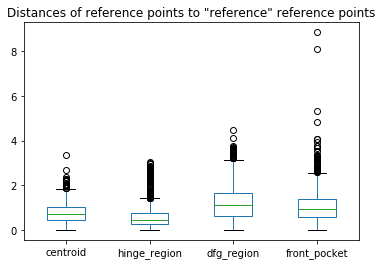

In [33]:
plot_distance_to_reference = distances_to_reference.plot(
    kind='box',
    title='Distances of reference points to "reference" reference points'
)

In [34]:
plot_distance_to_reference.get_figure().savefig(
    path_to_results / 'reference_points' / 'distance_refpoints_to_reference.png',
    dpi=300
)

In [35]:
save_cgo_outliers(distances_to_reference.centroid, 'centroid', path_to_results)
save_cgo_outliers(distances_to_reference.hinge_region, 'hinge_region', path_to_results)
save_cgo_outliers(distances_to_reference.dfg_region, 'dfg_region', path_to_results)
save_cgo_outliers(distances_to_reference.front_pocket, 'front_pocket', path_to_results)

## Front region

## Visualize reference points (PyMol)

In [36]:
def save_refpoints_as_cgo(klifs_metadata, path_to_results):
    """
    Save reference points as cgo file.
    
    Parameters
    ----------
    klifs_metadata : pandas.DataFrame
        Metadata KLIFS table.
    path_to_results : Path or str
        Path to kinsim_structure results folder.
    """
    
    path_to_results = Path(path_to_results)
    
    for index, row in klifs_metadata.iterrows():

        # Load structural data
        ml = KlifsMoleculeLoader(klifs_metadata_entry=row)

        # Calculate spatial features
        spatial = SpatialFeatures()
        spatial.from_molecule(ml.molecule)

        spatial.save_cgo_refpoints(row, output_path=path_to_results / 'reference_points' / 'cgo_reference_points')

### Write out a subset of cgo files

In [37]:
commands = [f'run {i}' for i in (path_to_results / 'reference_points' / 'cgo_reference_points').glob('*.py')]
commands[:3]

['run /home/dominique/Documents/Projects/kinsim_structure/examples/results/reference_points/cgo_reference_points/refpoints_p110g_1he8_chainA.py',
 'run /home/dominique/Documents/Projects/kinsim_structure/examples/results/reference_points/cgo_reference_points/refpoints_VRK1_6bru_altA_chainA.py',
 'run /home/dominique/Documents/Projects/kinsim_structure/examples/results/reference_points/cgo_reference_points/refpoints_CHK2_2w7x_altB_chainA.py']